In [99]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
from kaveh.behavioral import oculomotor
from kaveh.sorting import spikesorter
from kaveh.toolbox import find_file
import numpy as np
from matplotlib import pyplot as plt
from smr import File
import csv
import os

In [100]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
raw_files_with_8_dir_exp = []
with open('/mnt/data/temp/kaveh/2010_Adapt.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        if(row[1] == '/'):
            path, filename = os.path.split(row[0])
            f_name = find_file(filename[:-4], '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/')
            raw_files_with_8_dir_exp = raw_files_with_8_dir_exp + [f_name]
            

In [5]:
print(raw_files_with_8_dir_exp[0])

/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091608/B091608_1208_List.smr


In [106]:
cs_path = '/mnt/data/temp/kaveh/auto_processed/2010_Adapt' 
cs_files = [find_file(os.path.split(fn)[1] + '.pkl', cs_path) for fn in raw_files_with_8_dir_exp]


In [7]:
# Read detected CS
f_index = 0
with open(cs_files[f_index], 'rb') as input:
    sss = pickle.load(input)

In [8]:
smr_content = File(raw_files_with_8_dir_exp[f_index])
smr_content.read_channels()
chan_titles = [chan.title for chan in smr_content.channels]
for i, ct in enumerate(chan_titles):
    print("{}: {}".format(i, ct))

Not implemented (type = 6)
Not implemented (type = 5)
Not implemented (type = 5)
0: Unit
1: H Eye
2: V Eye
3: H Targ
4: V Targ
5: H2 Targ
6: V2 Targ
7: Aux 1
8: Aux 2
9: Accept Sp
10: Keyboard
11: Events


In [15]:
vt = smr_content.get_channel(4)
# ve = smr_content.get_channel(2)
ht = smr_content.get_channel(3)
# he = smr_content.get_channel(1)

voltage = smr_content.get_channel(0).data

# t_range = (0,700) #s
# fsize =  (20,5)
# i_range = [int(x/vt.dt) for x in t_range]
# prange = slice(i_range[0], i_range[1])

tt = oculomotor.target(vt.data, ht.data, ht.dt, '2d')
target_jumps_to, jump_vecs = tt.get_target_jumps(num_clusters=16, jump_tol= 150)


In [16]:
print(voltage.size*sss.dt)
print(tt.ht.size*tt.dt)

373.642
373.642


In [17]:
def convert_index(source_dt, dest_dt, source_index):
    """
    converts an index in a signal with source_dt period to an index in a signal with dest_dt period
    """
    t = source_index*source_dt
    dest_index = np.round(t/dest_dt)
    return dest_index

In [29]:
target_jumps_to_converted = {}
for jv in jump_vecs:
    target_jumps_to_converted[str(jv)] = convert_index(tt.dt, sss.dt, target_jumps_to[str(jv)])

In [39]:
cs_indices = sss.get_cs_spike_indices()


In [84]:
search_range = (0.050, 0.250) #in seconds; sets the range of time to look for a cs after target jump
i_range = [int(x/sss.dt) for x in search_range]
for jv in jump_vecs:
    target_indices = target_jumps_to_converted[str(jv)]
    for ti in target_indices:
        i_range = ti + i_range
        if np.any(np.logical_and(cs_indices <= i_range[1] , cs_indices >= i_range[0])):
            print(jv, i_range)
            
            
        

(array([-2780, -2781]), array([3188600., 3198600.]))


In [107]:
from neo.io import Spike2IO
from kaveh.toolbox import closest_argmin

search_range = (0.001, 0.500) #in seconds; sets the range of time to look for a cs after target jump
i_range = [int(x/sss.dt) for x in search_range]
for i, cf in enumerate(cs_files):
    print(cf)
    with open(cf, 'rb') as input:
        sss = pickle.load(input)
    print(raw_files_with_8_dir_exp[i])

    smr_content = File(raw_files_with_8_dir_exp[i])
    smr_content.read_channels()
    
    neo_reader = Spike2IO(filename=raw_files_with_8_dir_exp[i])
    neo_data = neo_reader.read()
    data_block = neo_data[0]
    seg = data_block.segments[0]
    # Assuming cs spike trains are saved in the 0th index of spike train channels
    cs_spiketrain = np.array(seg.spiketrains[0])
    cs_spiketrain = np.int32(cs_spiketrain/sss.dt)
    
    print('number of complex spikes from file ',cs_spiketrain.shape)
    
    
    
    
#     vt = smr_content.get_channel(4)
#     ht = smr_content.get_channel(3)
#     voltage = smr_content.get_channel(0).data

#     tt = oculomotor.target(vt.data, ht.data, ht.dt, '2d')
#     target_jumps_to, jump_vecs = tt.get_target_jumps(num_clusters=16, jump_tol= 150)
    
#     target_jumps_to_converted = {}
#     for jv in jump_vecs:
#         target_jumps_to_converted[str(jv)] = convert_index(tt.dt, sss.dt, target_jumps_to[str(jv)])
    cs_indices = sss.get_cs_spike_indices()
    print('number of complex spikes from alg ', cs_indices.shape)
#     print('number of simple spikes from alg ', sss.get_spike_indices())
#     for jv in jump_vecs:
#         target_indices = target_jumps_to_converted[str(jv)]
#         for ti in target_indices:
#             i_range = ti + i_range
#             if np.any(np.logical_and(cs_indices <= i_range[1] , cs_indices >= i_range[0])):
#                 print(jv, i_range)

/mnt/data/temp/kaveh/auto_processed/2010_Adapt/Buckley_12deg/B093008/B093008_1200_Adapt.smr.pkl
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B093008/B093008_1200_Adapt.smr
Not implemented (type = 6)
Not implemented (type = 6)
Not implemented (type = 6)
Not implemented (type = 5)
Not implemented (type = 5)
('number of complex spikes from file ', (950,))
('number of complex spikes from alg ', (2089,))
/mnt/data/temp/kaveh/auto_processed/2010_Adapt/Buckley_12deg/B091108/B091108_1200_Adapt.smr.pkl
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091108/B091108_1200_Adapt.smr
Not implemented (type = 6)
Not implemented (type = 6)
Not implemented (type = 5)
Not implemented (type = 5)
('number of complex spikes from file ', (91400,))
('number of complex spikes from alg ', (718,))
/mnt/data/temp/kaveh/auto_processed/2010_Adapt/Buckley_12deg/B100308_2/B100308_2_1412_Adapt.smr.pkl
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckl

<IPython.core.display.Javascript object>


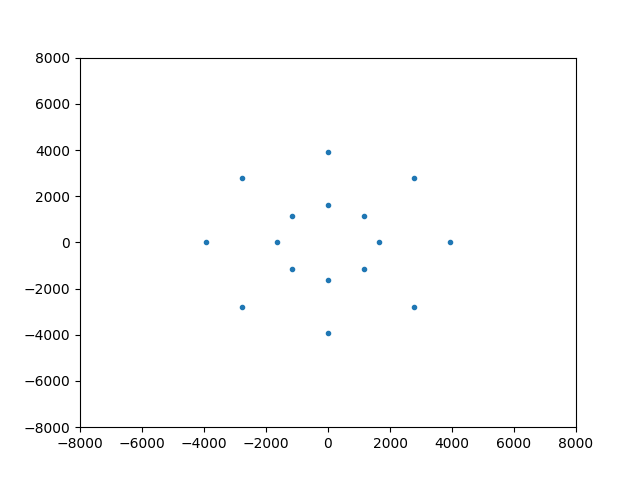

In [47]:
plt.figure()
plt.ylim(-8000, 8000)
plt.xlim(-8000, 8000)

plt.plot(jump_vecs[:,0], jump_vecs[:,1], '.')


In [ ]:
plt.figure(figsize=fsize)
plt.plot(tt.vt, alpha=0.3)
plt.ylim(-20000, 40000)

a = plt.axes([0.45, 0.60, 0.2, 0.2], facecolor = 'r', aspect='equal')
from kaveh.plots import axvlines
colors = plt.cm.jet(np.linspace(0, 1, len(jump_amps)))
# for i, jv in enumerate(jump_vecs):
#     axvlines(plt.gca(), target_jumps_to_converted[jv], color=colors[i])
# axvlines(plt.gca(), sss.get_cs_spike_indices(), color='m', alpha = 0.3)


In [ ]:
for jv in jump_vecs:
    print(jv)